In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!ls ../data/interim

enwiki-meta-parquet


In [3]:
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.getOrCreate()
df = spark.read.parquet("../data/interim/enwiki-meta-parquet")

In [4]:
%time df.count()

CPU times: user 622 µs, sys: 2.31 ms, total: 2.93 ms
Wall time: 5.17 s


116590880

In [5]:
df.rdd.getNumPartitions()

521

In [6]:
df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- rev_id: integer (nullable = true)
 |-- article_title: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- username: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- main: string (nullable = true)
 |-- talk: string (nullable = true)
 |-- user: string (nullable = true)
 |-- user_talk: string (nullable = true)
 |-- other: string (nullable = true)
 |-- external: string (nullable = true)
 |-- template: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- minor: boolean (nullable = true)
 |-- textdata: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- quarter: integer (nullable = true)



In [7]:
query = (
    df.groupBy("year", "quarter")
    .agg(F.countDistinct("article_id"))
    .orderBy("year", "quarter")
)

%time query.show(n=100)

+----+-------+--------------------------+
|year|quarter|count(DISTINCT article_id)|
+----+-------+--------------------------+
|2001|      1|                      1235|
|2001|      2|                      2470|
|2001|      3|                      5576|
|2001|      4|                     11401|
|2002|      1|                     31267|
|2002|      2|                     20854|
|2002|      3|                     42377|
|2002|      4|                     77441|
|2003|      1|                     50187|
|2003|      2|                     67912|
|2003|      3|                     90556|
|2003|      4|                    107742|
|2004|      1|                    164613|
|2004|      2|                    230571|
|2004|      3|                    311811|
|2004|      4|                    383966|
|2005|      1|                    375920|
|2005|      2|                    518441|
|2005|      3|                    663664|
|2005|      4|                    779541|
|2006|      1|                    

In [8]:
df.createOrReplaceTempView("enwiki")

In [11]:
query = """
select 
    category, 
    count(*)
from enwiki 
group by 1 
order by 2 desc
"""

spark.sql(query).show(truncate=False)

+-------------------------------------------+--------+
|category                                   |count(1)|
+-------------------------------------------+--------+
|null                                       |15613018|
|Discographies                              |63932   |
|Surnames                                   |58256   |
|Given_names                                |50417   |
|American_musical_groups                    |37441   |
|Living_people                              |32305   |
|Simpsons_episodes                          |30100   |
|Thomas_the_Tank_Engine_and_Friends         |26812   |
|Naruto                                     |26204   |
|Integers                                   |24667   |
|Uncategorised_people                       |23909   |
|September                                  |22860   |
|World_Wrestling_Entertainment_pay-per-views|22686   |
|November                                   |22447   |
|SpongeBob_SquarePants_episodes             |22019   |
|October  

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
query = """
with user_stats as (
    SELECT
        concat(year, '-', quarter) as period,
        user_id,
        count(distinct article_id) as degree
    from enwiki
    where 
        user_id is not null
    group by 1, 2
    order by 1
)

SELECT
    period,
    degree,
    count(user_id) as count
from user_stats
group by 1, 2
order by 1, 2
"""

spark.sql(query).count()

18675

In [45]:
df = spark.sql(query).toPandas()

In [87]:
len(set(df.period))

29

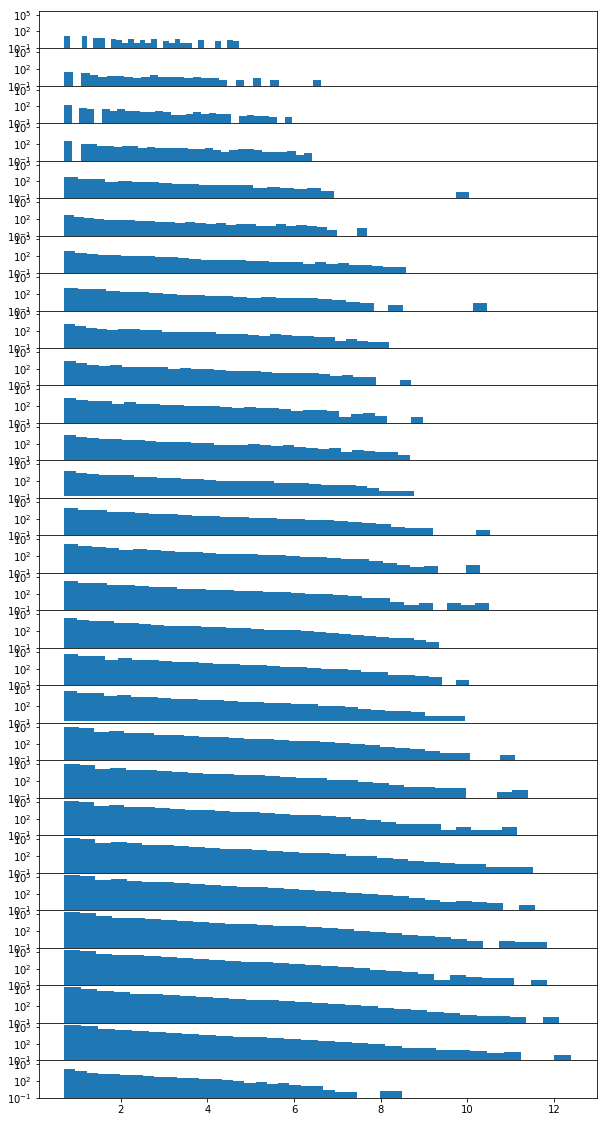

In [156]:
labels = sorted(set(df.period))
# Three subplots sharing both x/y axes
f, ax = plt.subplots(29, sharex=True, sharey=True, figsize=(10, 20))

for i, label in enumerate(labels):    
    test = df[(df.period == label) & (df.degree > 1)]
    ax[i].hist(
        np.log(test.degree), 
        bins=30, 
        weights=test['count'],
        #density=True,
        log=True,
        histtype='stepfilled',
        label=label,
    )
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

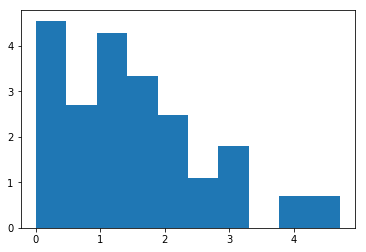

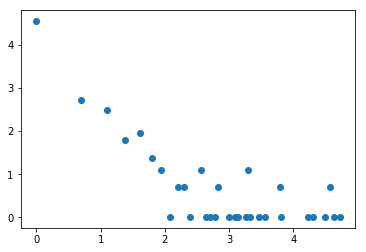

In [158]:
test = df[df.period == labels[0]]
plt.hist(np.log(test.degree), bins=10, weights=np.log(test['count']))
plt.show()

plt.scatter(np.log(test.degree), np.log(test['count']))
plt.show()

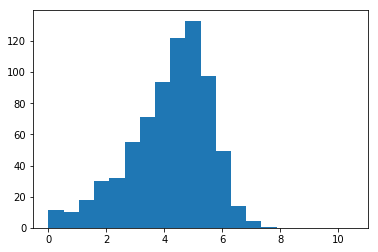

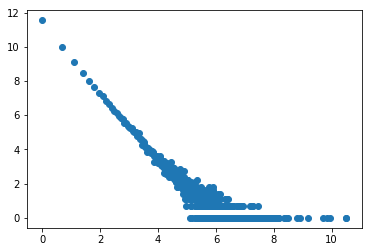

In [157]:
test = df[df.period == labels[15]]
plt.hist(np.log(test.degree), bins=20, weights=np.log(test['count']))
plt.show()

plt.scatter(np.log(test.degree), np.log(test['count']))
plt.show()

In [178]:
def get_edges(year, quarter):
    # assumes that the table is registered as `enwiki`
    query = """
    with subset as (
        SELECT 
            article_id,
            cast(user_id as int) as user_id,
            textdata
        FROM
            enwiki
        WHERE
            year = {} AND
            quarter = {}
    )

    SELECT
        user_id,
        article_id,
        sum(textdata) as word_count
    FROM subset
    WHERE user_id is not null
    GROUP BY 1, 2
    """.format(year, quarter)

    res = spark.sql(query)
    return res

def print_stats(df):
    edges = df.count()
    users = df.select("user_id").distinct().count()
    articles = df.select("article_id").distinct().count()
    print("edges: {}\nusers: {}\narticles: {}".format(edges, users, articles))

res = get_edges(2007, 1)
%time print_stats(res)

edges: 4694179
users: 354500
articles: 1291873
CPU times: user 4.19 ms, sys: 5.98 ms, total: 10.2 ms
Wall time: 18.1 s


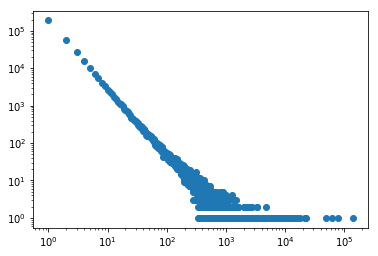

In [189]:
def plot_degree_distribution(df):
    df.createOrReplaceTempView("temp")
    query = """
    with user_stats as (
        select 
            user_id, 
            count(distinct article_id) as degree
        from temp
        group by 1
    )

    select
        degree,
        count(distinct user_id) as n_users
    from user_stats
    group by 1
    """
    deg = spark.sql(query).toPandas()
    
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(deg.degree, deg.n_users)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()


plot_degree_distribution(res)

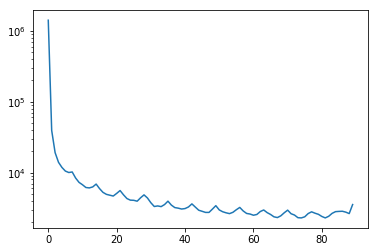

In [185]:
def plot_days_between_contributions(year, quarter):
    query = """
    with user_stats as (
        select
            user_id,
            datediff(max(timestamp), min(timestamp)) as days
        from enwiki
        where year = {} and quarter = {}
        group by 1
    )
    select
        days,
        count(distinct user_id) as n_users
    from user_stats
    group by 1
    order by 1
    """.format(year, quarter)
    
    res = spark.sql(query).toPandas()
    plt.semilogy(res.days, res.n_users)
    plt.show()

    
plot_days_between_contributions(2007, 1)

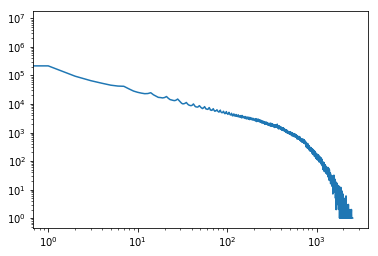

In [190]:
query = """
with user_stats as (
    select
        user_id,
        datediff(max(timestamp), min(timestamp)) as days
    from enwiki
    group by 1
)
select
    days,
    count(distinct user_id) as n_users
from user_stats
group by 1
order by 1
"""

res = spark.sql(query).toPandas()
plt.loglog(res.days, res.n_users)
plt.show()

In [225]:
df1 = get_edges(2007, 1)
df2 = get_edges(2007, 2)
df3 = get_edges(2007, 3)
df4 = get_edges(2007, 4)

In [193]:
print_stats(df1)
print_stats(df2)

edges: 4694179
users: 354500
articles: 1291873
edges: 4667370
users: 340806
articles: 1373819


In [227]:
def jaccard(df1, df2):
    # percentage of things in the intersection out of the total possible from the left
    set1 = df1.select("user_id").distinct()
    set2 = df2.select("user_id").distinct()
    intersection = set1.join(set2, "user_id", "inner").count()
    original = set1.count()
    return intersection*1.0/original

# baseline
print jaccard(df1, df2)
print jaccard(df1, df3)
print jaccard(df1, df4)

0.307870239774
0.234318758815
0.209497884344


In [229]:
# TODO: normalize by frequency
def print_jaccard_by_word_count_quantile(df1, df2):
    qt = df1.approxQuantile("word_count", [.25, .5, .75], 0.001)
    print(qt)

    clauses = [
        "word_count < {}".format(qt[0]),
        "word_count > {} AND word_count < {}".format(qt[0], qt[1]),
        "word_count > {} AND word_count < {}".format(qt[1], qt[2]),
        "word_count > {}".format(qt[2]),
    ]

    for clause in clauses:
        print(jaccard(df1.where(clause), df2.where(clause)))

print_jaccard_by_word_count_quantile(df1, df2)

[280.0, 808.0, 2519.0]
0.282680913418
0.306088046509
0.308611799968
0.310006374829


In [230]:
print_jaccard_by_word_count_quantile(df1, df3)

[280.0, 808.0, 2523.0]
0.218970993784
0.24156238969
0.243445915433
0.237920998798


In [231]:
print_jaccard_by_word_count_quantile(df1, df4)

[281.0, 804.0, 2521.0]
0.190468843592
0.212184828325
0.216771523277
0.212093582169


In [222]:
def user_article_degree(df):
    # maybe a source of subtle bugs if the view isn't materialized
    df.createOrReplaceTempView("temp")
    query = """
    select 
        user_id, 
        count(distinct article_id) as degree
    from temp
    group by 1
    """
    return spark.sql(query).where("degree > 1")


def print_jaccard_by_degree_quantiles(df1, df2):
    df1, df2 = map(user_article_degree, [df1, df2])
    
    qt = df1.approxQuantile("degree", [.25, .5, .75], 0.001)
    print(qt)

    clauses = [
        "degree <= {}".format(qt[0]),
        "degree > {} AND degree <= {}".format(qt[0], qt[1]),
        "degree > {} AND degree <= {}".format(qt[1], qt[2]),
        "degree > {}".format(qt[2]),
    ]

    for clause in clauses:
        print(jaccard(df1.where(clause), df2.where(clause)))

    
print_jaccard_by_degree_quantiles(df1, df2)

[2.0, 3.0, 8.0]
0.0563515825492
0.044730828307
0.145308843344
0.54484429415


In [223]:
print_jaccard_by_degree_quantiles(df1, df3)

[2.0, 3.0, 8.0]
0.0372647562019
0.0300827932417
0.0972980639671
0.427774693383


In [224]:
print_jaccard_by_degree_quantiles(df1, df4)

[2.0, 3.0, 8.0]
0.0330945252352
0.0259243996553
0.081790889535
0.369252510978
